- competition: https://www.kaggle.com/c/store-sales-time-series-forecasting/overview
- time series courses: 
    - https://www.udemy.com/course/python-for-time-series-data-analysis/
    - https://www.kaggle.com/learn/time-series

#### Import libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import sys
import datetime

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### time series libraries 
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, grangercausalitytests # 1 to test stationarity, 2 for causality

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # ACF and PACF for determining (p,q) orders
from pmdarima import auto_arima  ## choosing ARIMA orders

from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults


# from statsmodels.tools.eval_measures import bic   ## BIC, Bayesian Information Criterion
from statsmodels.graphics.tsaplots import month_plot,quarter_plot, seasonal_plot

from statsmodels.tools.eval_measures import mse,rmse, meanabs  ## model evaluation

# Recurrent Neural Networks
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Facebook Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from fbprophet.plot import add_changepoints_to_plot


In [108]:
## Just a nicer display for plots
def nice_plotting(title ='', xlabel='', ylabel='', new_fig= False , figsize= (10,6), title_size=18):
    if new_fig== True:
        plt.figure(figsize=figsize)
        
    plt.title(title, color= 'xkcd:pale red', fontsize= title_size, pad= 13, fontweight= 'bold')
    plt.xlabel(xlabel, color='xkcd:pale red', fontsize= 14, fontweight= 'bold')
    plt.ylabel(ylabel, color= 'xkcd:pale red', fontsize= 14, fontweight= 'bold')
    plt.xticks(fontsize=12, color= 'xkcd:cadet blue')
    plt.yticks(fontsize=12, color= 'xkcd:cadet blue')

#### Reading Data

In [4]:
basic_path = './Data/'

all_stores= pd.read_csv(basic_path + 'train.csv')

print(all_stores.shape)
all_stores.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


<b> Filtering only one store to get univariate TS

In [5]:
ts_1= all_stores[all_stores['store_nbr'] == 1]
ts_1.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [6]:
ts_1['sales'].describe(percentiles = np.arange(0.1,1,0.1) )

count    55572.000000
mean       254.534889
std        596.827146
min          0.000000
10%          0.000000
20%          0.000000
30%          2.000000
40%          7.000000
50%         19.000000
60%         66.000000
70%        134.012300
80%        254.221400
90%        727.000000
max       9065.000000
Name: sales, dtype: float64

##### Creating weekly dataset

In [7]:
ts_1['date']= pd.to_datetime(ts_1['date'])
ts_1.set_index('date', inplace = True)

ts_1.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0.0
2013-01-01,1,1,BABY CARE,0.0,0.0
2013-01-01,2,1,BEAUTY,0.0,0.0
2013-01-01,3,1,BEVERAGES,0.0,0.0
2013-01-01,4,1,BOOKS,0.0,0.0


In [8]:
relevant_cols = ['sales']

## Making it daily
df= round(ts_1[relevant_cols].groupby(ts_1.index).sum(), 2)

## Making it weekly
df= df.resample('W').sum().iloc[:-1]


print(df.shape)
df.head()

(241, 1)


,sales
date,
2013-01-06,27728.15
2013-01-13,36970.07
2013-01-20,36721.33
2013-01-27,34954.87
2013-02-03,34247.47


In [9]:
### Adding rolling mean

df['MA_6weeks']= df['sales'].rolling(window = 6).mean()
df['MA_12weeks'] = df['sales'].rolling(window= 12).mean()

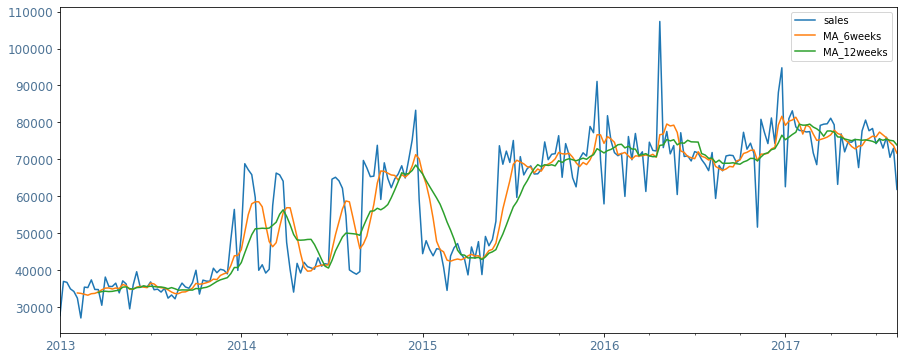

In [10]:
df.plot(figsize= (15,6)).autoscale(axis='x',tight=True);
nice_plotting(new_fig= False)

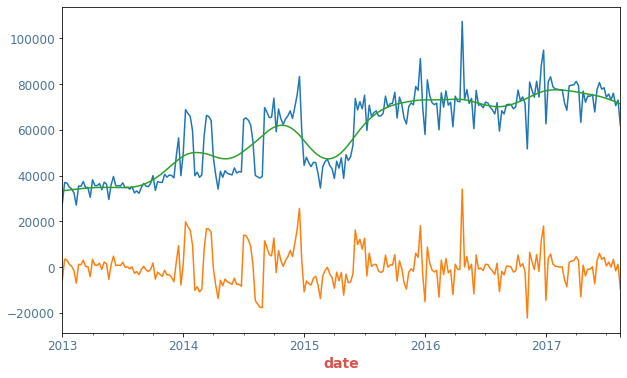

In [11]:
## Hodrick-Prescott filter
nice_plotting()

cycle, trend = hpfilter(df['sales'], lamb=1600)

df['sales'].plot()
cycle.plot()
trend.plot();

#### ETS decomposition (Error/Trend/Seasonality)

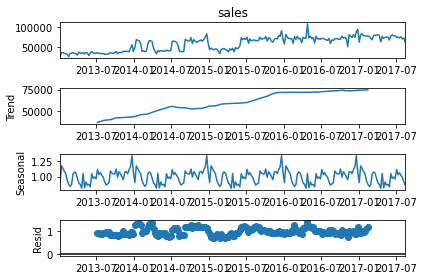

In [12]:
result = seasonal_decompose(df['sales'], model='multiplicative')  # model='mul' also works
result.plot();

<AxesSubplot:xlabel='date'>

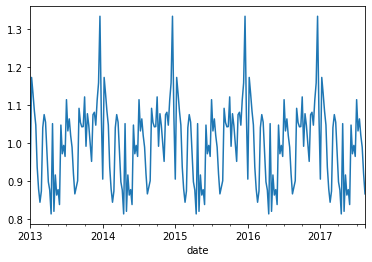

In [13]:
### plotting only one of them, e.g. seasonal

result.seasonal.plot()

#### Exposing Seasonality with Month and Quarter Plots
Statsmodels has two plotting functions that group data by month and by quarter. Note that if the data appears as months, you should employ <em>resampling</em> with an aggregate function before running a quarter plot. These plots return a <tt>matplotlib.Figure</tt> object.

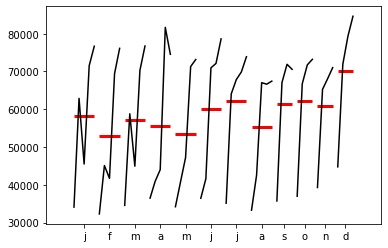

In [14]:
# red bars is average, it is a seasnoal plot

month_plot(df.resample('M').mean()['sales']);

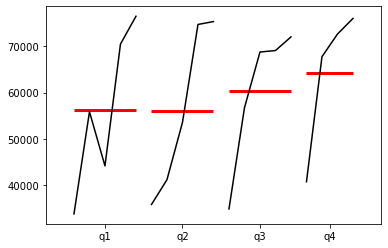

In [15]:
# red bars is average, it is a quarter plot

quarter_plot(df.resample(rule='Q').mean()['sales']); 

### Exponential Moving Average (EWMA)
We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

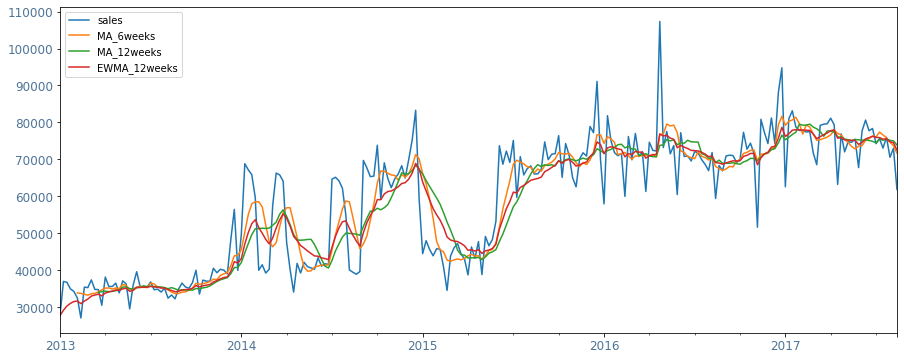

In [16]:
df['EWMA_12weeks'] = df['sales'].ewm(span=12,adjust=False).mean()

df.plot(figsize= (15,6)).autoscale(axis='x',tight=True);
nice_plotting(new_fig= False)

#### Simple Exponential Smoothing / Simple Moving Average</font>
This is the simplest to forecast. $\hat{y}$ is equal to the most recent value in the dataset, and the forecast plot is simply a horizontal line extending from the most recent value.
#### Double Exponential Smoothing / Holt's Method</font>
This model takes trend into account. Here the forecast plot is still a straight line extending from the most recent value, but it has slope.
#### Triple Exponential Smoothing / Holt-Winters Method</font>
This model has (so far) the "best" looking forecast plot, as it takes seasonality into account. When we expect regular fluctuations in the future, this model attempts to map the seasonal behavior.

### Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

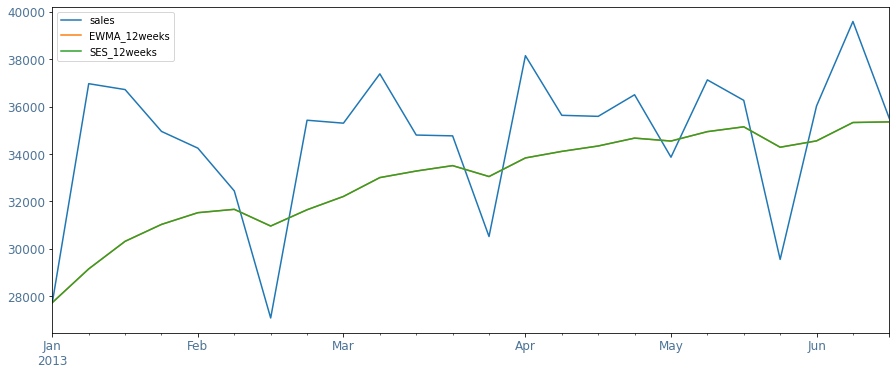

In [20]:
span = 12
alpha = 2/(span+1)

df['SES_12weeks']=SimpleExpSmoothing(df['sales']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

df.iloc[:24][['sales', 'EWMA_12weeks', 'SES_12weeks']].plot(figsize= (15,6)).autoscale(axis='x',tight=True);
nice_plotting(new_fig= False)

<b> ok, so Simple Exponential Smooting is useless, it is the equivalent of .ewm

### Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [21]:
df['DES_add12'] = ExponentialSmoothing(df['sales'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,sales,MA_6weeks,MA_12weeks,EWMA_12weeks,SES_12weeks,DES_add12
date,,,,,,
2013-01-06,27728.15,NaN,NaN,27728.150000,27728.150000,39482.254904
2013-01-13,36970.07,NaN,NaN,29149.983846,29149.983846,46311.006366
2013-01-20,36721.33,NaN,NaN,30314.806331,30314.806331,47827.398201
2013-01-27,34954.87,NaN,NaN,31028.662280,31028.662280,46347.471596
2013-02-03,34247.47,NaN,NaN,31523.863468,31523.863468,44616.857583


### Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 

In [138]:
df['TES_add12'] = ExponentialSmoothing(df['sales'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

,sales,MA_6weeks,MA_12weeks,EWMA_12weeks,SES_12weeks,DES_add12,TES_add12
date,,,,,,,
2013-01-06,27728.15,NaN,NaN,27728.150000,27728.150000,26071.490858,30125.039980
2013-01-13,36970.07,NaN,NaN,29149.983846,29149.983846,32306.104941,31704.107069
2013-01-20,36721.33,NaN,NaN,30314.806331,30314.806331,34936.709335,37178.158172
2013-01-27,34954.87,NaN,NaN,31028.662280,31028.662280,35123.044532,36237.660444
2013-02-03,34247.47,NaN,NaN,31523.863468,31523.863468,34812.564305,35921.961747


In [139]:
## it is too complex, too much for this data

df['TES_mul12'] = ExponentialSmoothing(df['sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,sales,MA_6weeks,MA_12weeks,EWMA_12weeks,SES_12weeks,DES_add12,TES_add12,TES_mul12
date,,,,,,,,
2013-01-06,27728.15,NaN,NaN,27728.150000,27728.150000,26071.490858,30125.039980,3.179699e+06
2013-01-13,36970.07,NaN,NaN,29149.983846,29149.983846,32306.104941,31704.107069,4.595317e+08
2013-01-20,36721.33,NaN,NaN,30314.806331,30314.806331,34936.709335,37178.158172,4.931406e+10
2013-01-27,34954.87,NaN,NaN,31028.662280,31028.662280,35123.044532,36237.660444,5.057554e+12
2013-02-03,34247.47,NaN,NaN,31523.863468,31523.863468,34812.564305,35921.961747,5.323989e+14


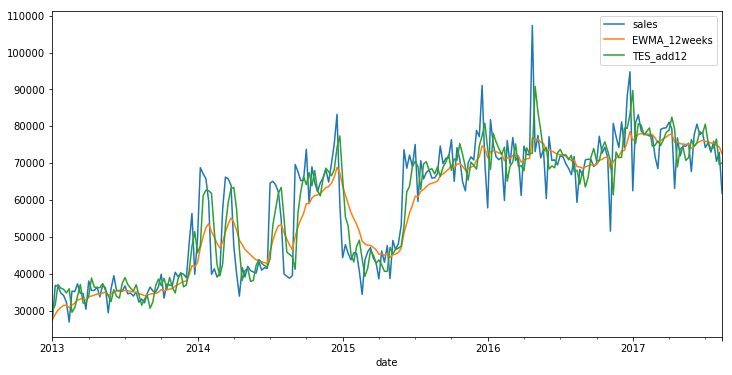

In [143]:
df[['sales', 'EWMA_12weeks','TES_add12',]].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

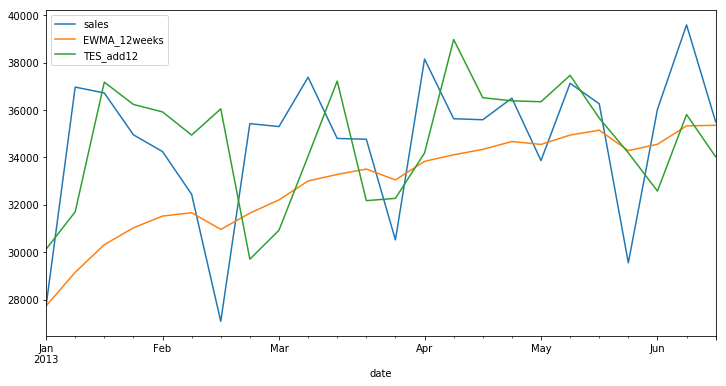

In [145]:
df[['sales', 'EWMA_12weeks','TES_add12',]].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [147]:
df.index

DatetimeIndex(['2013-01-06', '2013-01-13', '2013-01-20', '2013-01-27',
               '2013-02-03', '2013-02-10', '2013-02-17', '2013-02-24',
               '2013-03-03', '2013-03-10',
               ...
               '2017-06-11', '2017-06-18', '2017-06-25', '2017-07-02',
               '2017-07-09', '2017-07-16', '2017-07-23', '2017-07-30',
               '2017-08-06', '2017-08-13'],
              dtype='datetime64[ns]', name='date', length=241, freq='W-SUN')

## Stationarity Test:  Dickey-Fuller

Time series data is said to be stationary if it does not exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.

In [154]:
def adf_test(series, alpha= 0.05, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= alpha:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [156]:
adf_test(df['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.725988
p-value                   0.417775
# lags used              10.000000
# observations          230.000000
critical value (1%)      -3.459106
critical value (5%)      -2.874190
critical value (10%)     -2.573512
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


##### Differencing data
 Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.

In [191]:
df1= df[['sales']].diff().dropna()
df1.head()

,sales
date,
2013-01-13,9241.92
2013-01-20,-248.74
2013-01-27,-1766.46
2013-02-03,-707.40
2013-02-10,-1804.45


In [162]:
### stationarity test
adf_test(df1['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.611635e+00
p-value                 6.355404e-09
# lags used             9.000000e+00
# observations          2.300000e+02
critical value (1%)    -3.459106e+00
critical value (5%)    -2.874190e+00
critical value (10%)   -2.573512e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

<a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

##### Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

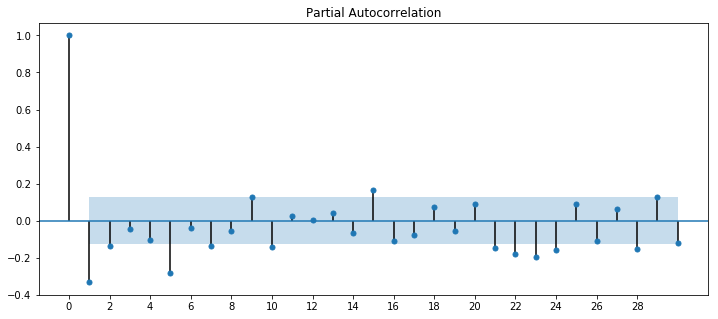

In [179]:
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df1['sales'], lags=30, ax=ax)
ax.set_xticks(np.arange(0,30,2));

<b> High level concept </b> If a lag is significant, it means that correlation with such lag is not neglectable, thus it makes sense to include it. Viceversa, if it is not, we can neglect it.

Suggested order for AR is 2, because first two lags are significative and 3rd is not.

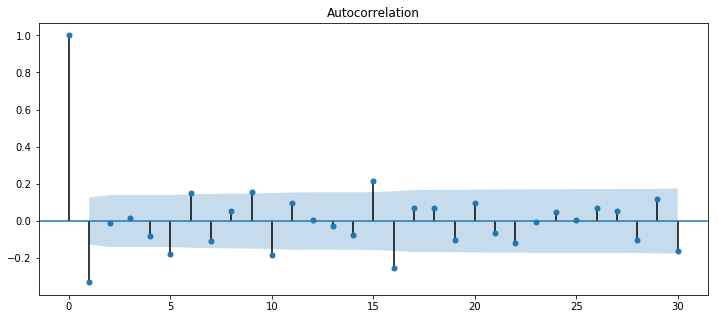

In [173]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df1['sales'], lags=30, ax=ax);

For MA only one lag is significant, thus order should be ARIMA(2, d, 1) <br> 
NOTE: the df is already differenced and stationary, we don't need d

# Choosing ARIMA Orders

  
Before we can apply an ARIMA forecasting model, we need to review the components of one.<br>
ARIMA, or Autoregressive Independent Moving Average is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [184]:
auto_arima(df1['sales'], information_criterion= 'bic').summary()

C:\Users\fedfran\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2485.729
Date:                Wed, 24 Nov 2021   AIC                           4981.457
Time:                        16:51:28   BIC                           4998.860
Sample:                             0   HQIC                          4988.469
                                - 240                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     59.0982     15.007      3.938      0.000      29.686      88.511
ar.L1          0.5161      0.057      9.029      0.000       0.404       0.628
ar.L2          0.1845      0.068      2.718      0.007       0.051       0.318
ma.L1         -0.9974      0.072    -13.828      0.000      -1.139      -0.856
sigma2      6.301e+07   1.52e-05   4.15e+12      0.000     6.3e+07     6.3e+07
===================================================================================
Ljung-Box (Q):                       92.28   Jarque-Bera (JB):               112.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             0.53
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.69e+27. Standard errors may be unstable.
"""

<b> As seen before, the one suggested is ARIMA(2,0,1). If we applied this to original df it would have been ARIMA(2,1,1). <br>
    
From now on, I will use original data and apply differencing only withing ARIMA model

### Split the data into train/test sets (here consider test set as for validation - I can never choose parameters based on test). Theoretically I should split into train/validation/test, choosing parameters based on validation.
As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast.

In [592]:
df['sales'].index.freq

<Week: weekday=6>

In [593]:
df_1.shape

(240, 1)

In [414]:
test_size= 28 #4 weeks

# Set one month for testing
train = df.iloc[:len(df) - test_size]
test = df.iloc[len(train):]

train.shape, test.shape

((213, 6), (28, 6))

In [596]:
stepwise_fit = auto_arima(
                train['sales'],
                start_p=0,
                start_q=0,
                max_p=6,
                max_q=3,
                seasonal=True,
                m=7,  ## m=7 bcs weekly data
                trace=True,
                stepwise=True,  # set to stepwise, which is the default though. So, this all can stop early
                information_criterion='bic',
                maxiter=1000,
                random_state=42)

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=4454.202, BIC=4467.629, Fit time=0.255 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4454.237, BIC=4460.950, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4437.325, BIC=4450.751, Fit time=0.087 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4432.064, BIC=4445.491, Fit time=0.084 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4433.851, BIC=4450.634, Fit time=0.394 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4430.471, BIC=4440.541, Fit time=0.080 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4419.943, BIC=4433.369, Fit time=0.692 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4435.784, BIC=4445.854, Fit time=0.091 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  213
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2205.971
Date:                Fri, 26 Nov 2021   AIC                           4419.943
Time:                        13:17:42   BIC                           4433.369
Sample:                             0   HQIC                          4425.370
                                - 213                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.4865     15.484      5.650      0.000      57.138     117.835
ar.L1          0.6270      0.057     10.990      0.000       0.515       0.739
ma.L1         -0.9984      0.089    -11.213      0.000      -1.173      -0.824
sigma2      6.755e+07   8.68e-08   7.78e+14      0.000    6.76e+07    6.76e+07
===================================================================================
Ljung-Box (Q):                       89.59   Jarque-Bera (JB):                60.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.75e+32. Standard errors may be unstable.
"""

<b> Here I have decreased the data size (run on train rather than df) and I have 1 degree less for AR. Why? Due to power of the test, which is proportional to sample size. By decreasing sample size, it is more difficult to detect smth which is not too significant.

## Fit an ARIMA Model with chosen order

In [415]:
model = ARIMA(train['sales'], order= (1,1,1))
fitted_arima= model.fit()

fitted_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                  212
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2203.943
Method:                       css-mle   S.D. of innovations           7845.506
Date:                Thu, 02 Dec 2021   AIC                           4415.886
Time:                        15:44:58   BIC                           4429.313
Sample:                    01-13-2013   HQIC                          4421.313
                         - 01-29-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           224.9273     22.014     10.217      0.000     181.781     268.074
ar.L1.D.sales     0.6115      0.055     11.138      0.000       0.504       0.719
ma.L1.D.sales    -1.0000      0.014    -70.381      0.000      -1.028      -0.972
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6353           +0.0000j            1.6353            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [416]:
#typ= 'levels' is to keep predictions in the same scale of original data, otherwise it will yield the diff ones

start=len(train)
end=len(train)+len(test)-1

train_pred_arima= fitted_arima.predict(start= 1, end= len(train), typ= 'levels')
test_pred_arima = fitted_model.predict(start=start, end=end, typ='levels' ).rename('ARMA(1,1,1) Predictions') 

In [417]:
df.tail()

,sales,MA_6weeks,MA_12weeks,EWMA_12weeks,SES_12weeks,DES_add12
date,,,,,,
2017-07-16,73050.20,76613.880000,75170.648333,75462.464073,75462.464073,73732.996072
2017-07-23,75973.00,75836.790000,75499.122500,75541.008062,75541.008062,75181.392155
2017-07-30,70559.26,74637.690000,75150.112500,74774.585283,74774.585283,71774.464544
2017-08-06,73001.49,73743.678333,75013.155000,74501.801394,74501.801394,72334.744077
2017-08-13,61877.27,71679.641667,73881.708333,72559.565795,NaN,NaN


<b> Usually ARIMA is a line, similar to an average or a trend, not too sophisticated. On the other hand, if you think about that, it is a linear regression where the independent variables are the lags...

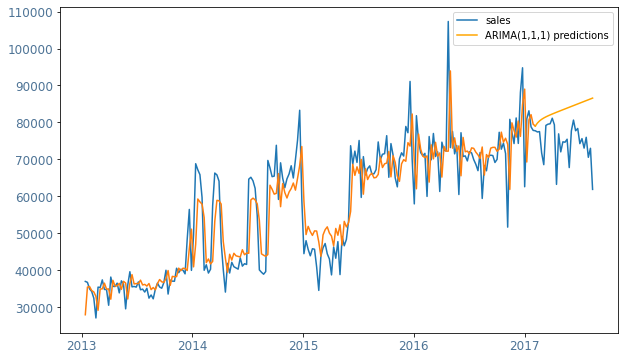

In [418]:
nice_plotting(new_fig=True)
plt.plot(df.iloc[1:]['sales'], label='sales')
plt.plot(train_pred_arima)
plt.plot(test_pred_arima, color='orange', label='ARIMA(1,1,1) predictions')
plt.legend();

#### Forecasting into the unknown future - inverting differencing with internal parameter

- I have to retrain the model (with the order found on the train) on the whole data - rather than keeping just the one on the train set - to forecast into the unknown future. <br>

- I have to apply reverse transformation of differencing (cumsum) to be in the same original scale, but to have a qualitative idea of our forecast it is also ok to plot the differenced versions.

- Sometimes such inverse transformaiton is done internally, with a parameter such as typ='levels'

In [419]:
## Retraining on the whole data

model = ARIMA(df['sales'], order= (1,1,1))
fitted_model= model.fit()

In [420]:
## typ = 'levels' is needed to get back to original df, without diff

start= len(df)
end= len(df) + test_size

forecast_unkown= fitted_model.predict(start = start,
                                     end= end , typ ='levels').rename('ARIMA(1,1,1) Forecast') 

len(forecast_unkown)

29

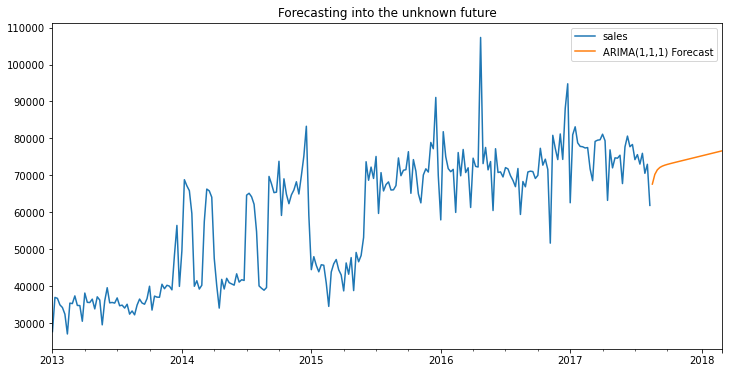

In [421]:
# Plot predictions against known values
title = 'Forecasting into the unknown future'
ylabel=''
xlabel='' # we don't really need a label here

ax = df['sales'].plot(legend=True,figsize=(12,6),title=title)
forecast_unkown.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### SARIMA(p,d,q)(P,D,Q)m
### Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables.

In [422]:
## In autoarima we already put seasonal= True but the best model was without seasonal.
## This, here I am putting a seasonal order which in auto_arima had a good BIC

model = SARIMAX(
        train['sales'],
        order=(1, 1, 1),
        seasonal_order=(1, 0, 1, 7),
)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                  213
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2207.453
Date:                           Thu, 02 Dec 2021   AIC                           4424.907
Time:                                   15:45:19   BIC                           4441.690
Sample:                               01-06-2013   HQIC                          4431.690
                                    - 01-29-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4300      0.097      4.427      0.000       0.240       0.620
ma.L1         -0.8005      0.078    -10.237      0.000      -0.954      -0.647
ar.S.L7        0.5726      0.353      1.622      0.105      -0.119       1.265
ma.S.L7       -0.6704      0.330     -2.032      0.042      -1.317      -0.024
sigma2      6.804e+07   5.17e-10   1.32e+17      0.000     6.8e+07     6.8e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                67.78
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+33. Standard errors may be unstable.
"""

In [423]:
start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start=start,
                              end=end,
                              dynamic=False,
                              typ='levels').rename('SARIMA Predictions')

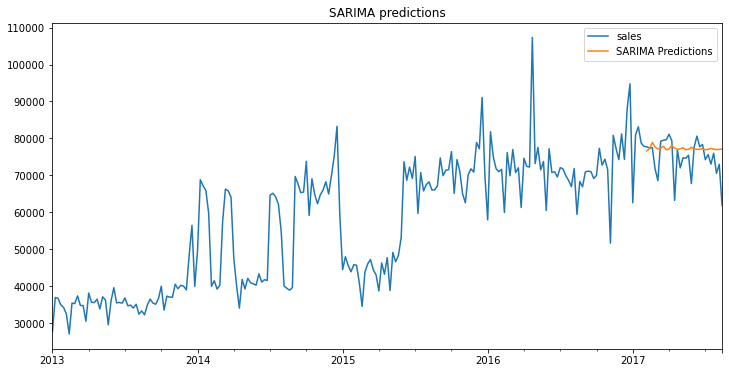

In [424]:
title = 'SARIMA predictions'
ylabel=''
xlabel='' # we don't really need a label here

ax = df['sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# SARIMAX

## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.


- for instance holiday can be an exogenous factor. It is not a variable which influence series reciprocally, it is only unidirectional. Holiday influences sales but not the opposite. 
- we don't need to forecast exogenous variable; you know holidays even in the future, it is not a variable

<b> adding exogenous variable in the dataset: holidays

In [425]:
holidays= pd.read_csv(basic_path + 'holidays_events.csv', parse_dates=True )

holidays['date'] = pd.to_datetime(holidays['date'])

holidays.set_index('date', inplace=True)
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [426]:
dict_holidays= {}

for d in holidays.index:
    dict_holidays[d] = 1

    
set(dict_holidays.keys()).intersection(set(df.index)) ## no common dates, it does not work well bcs it is not true


## WORKING METHOD
## taking n days around holidays for the mapping

window = 0  ### must be exaclty the same day

dict_holidays= {}

for h in holidays.index:
    start= h - datetime.timedelta(days=window)
    end= h + datetime.timedelta(days=window)
    
    for d in df.index:
        
#         if h.year == d.year:
#             print(f'h is {h} and d is {d}')
#             print(f'start is {start} and end is {end}')
#             print('\n')
            
        if start <= d <= end:
            dict_holidays[d] = 1
        else:
            if d not in dict_holidays:
                dict_holidays[d] = 0

In [427]:
df['is_holiday'] = df.index.map(dict_holidays)

print('Number of holidays is: ', df[df['is_holiday'] == 1].shape[0] )

df.head()

Number of holidays is:  36


,sales,MA_6weeks,MA_12weeks,EWMA_12weeks,SES_12weeks,DES_add12,is_holiday
date,,,,,,,
2013-01-06,27728.15,NaN,NaN,27728.150000,27728.150000,39482.254904,0
2013-01-13,36970.07,NaN,NaN,29149.983846,29149.983846,46311.006366,0
2013-01-20,36721.33,NaN,NaN,30314.806331,30314.806331,47827.398201,0
2013-01-27,34954.87,NaN,NaN,31028.662280,31028.662280,46347.471596,0
2013-02-03,34247.47,NaN,NaN,31523.863468,31523.863468,44616.857583,0


In [647]:
## doing again split into train and test
rel_cols = ['sales', 'is_holiday']

test_size= 28 

# Set one month for testing
train = df.iloc[:len(df1) - test_size +1][rel_cols]
test = df.iloc[len(train):][rel_cols]

train.shape, test.shape

((213, 2), (28, 2))

#### Fitting SARIMAX with exogenous variable

In [648]:
stepwise_fit = auto_arima(
                train['sales'],
                exogenous = train['is_holiday'].values.reshape(-1, 1),
                start_p=0,
                start_q=0,
                max_p=6,
                max_q=3,
                seasonal=True,
                m=7,  ## m=7 bcs weekly data
                trace=True,
                stepwise= True,  # set to stepwise, which is the default though. So, this all can stop early
                information_criterion='bic',
                maxiter=1000,
                random_state=42, )

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=4455.976, BIC=4472.759, Fit time=0.320 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4455.935, BIC=4466.005, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4438.964, BIC=4455.746, Fit time=0.132 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4433.833, BIC=4450.616, Fit time=0.129 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4435.647, BIC=4455.787, Fit time=0.821 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4432.269, BIC=4445.696, Fit time=0.093 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4427.785, BIC=4444.568, Fit time=0.146 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4437.444, BIC=4450.870, Fit time=0.085 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  213
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2208.892
Date:                Fri, 26 Nov 2021   AIC                           4427.785
Time:                        13:33:02   BIC                           4444.568
Sample:                             0   HQIC                          4434.568
                                - 213                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    328.1369    146.235      2.244      0.025      41.522     614.752
x1          -665.9377   1380.992     -0.482      0.630   -3372.632    2040.757
ar.L1          0.3680      0.100      3.690      0.000       0.173       0.563
ma.L1         -0.7673      0.083     -9.262      0.000      -0.930      -0.605
sigma2      6.786e+07      0.017   4.06e+09      0.000    6.79e+07    6.79e+07
===================================================================================
Ljung-Box (Q):                       82.28   Jarque-Bera (JB):                60.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.25e+25. Standard errors may be unstable.
"""

In [649]:
model = SARIMAX(train['sales'],exog=train['is_holiday'],order=(1,1,1),enforce_invertibility=False) #seasonal_order=(2,0,0,7)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                  213
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2208.722
Date:                Fri, 26 Nov 2021   AIC                           4425.444
Time:                        13:33:21   BIC                           4438.871
Sample:                    01-06-2013   HQIC                          4430.871
                         - 01-29-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday  -665.9377   1361.503     -0.489      0.625   -3334.434    2002.559
ar.L1          0.4473      0.091      4.898      0.000       0.268       0.626
ma.L1         -0.8191      0.068    -11.973      0.000      -0.953      -0.685
sigma2      6.797e+07      0.021   3.19e+09      0.000     6.8e+07     6.8e+07
===================================================================================
Ljung-Box (Q):                       84.91   Jarque-Bera (JB):                61.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.23e+25. Standard errors may be unstable.
"""

In [650]:
# Obtain predicted values with exogenous variable
start = len(train)
end = len(train) + len(test) - 1
exog_forecast = test[['is_holiday'
                      ]]  # requires two brackets to yield a shape of (35,1)

predictions = fitted_model.predict(
    start=start, end=end, exog=exog_forecast,
    typ='levels').rename('SARIMAX(1,1,1) Predictions')

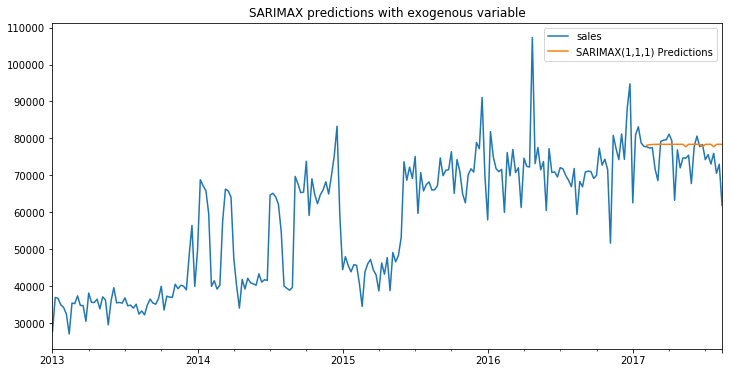

In [654]:
title = 'SARIMAX predictions with exogenous variable'
ylabel=''
xlabel='' # we don't really need a label here

ax = df['sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### model evaluation

In [655]:
error1x = mse(test['sales'], predictions)
error2x = rmse(test['sales'], predictions)
adj_mape= error2x*100/test['sales'].mean()

# Print new SARIMAX values
print(f'SARIMAX MSE Error: {error1x:11.10}')
print(f'SARIMAX RMSE Error: {error2x:11.10}')
print(f'SARIMAX Adjusted MAPE Error: {adj_mape:11.10}%')

SARIMAX MSE Error: 35675485.59
SARIMAX RMSE Error: 5972.895913
SARIMAX Adjusted MAPE Error: 7.981045815%


# Multivatiate Approach

Adding another time series into it

### VAR(p) - Vector Autoregression
In our previous SARIMAX example, the forecast variable $y_t$ was influenced by the exogenous predictor variable, but not vice versa. That is, the occurrence of a holiday affected restaurant patronage but not the other way around.

However, there are some cases where variables affect each other. <a href='https://otexts.com/fpp2/VAR.html'>Forecasting: Principles and Practice</a> describes a case where changes in personal consumption expenditures $C_t$ were forecast based on changes in personal disposable income $I_t$.
> However, in this case a bi-directional relationship may be more suitable: an increase in $I_t$ will lead to an increase in $C_t$ and vice versa.<br>An example of such a situation occurred in Australia during the Global Financial Crisis of 2008–2009. The Australian government issued stimulus packages that included cash payments in December 2008, just in time for Christmas spending. As a result, retailers reported strong sales and the economy was stimulated. Consequently, incomes increased.

Aside from investigating multivariate time series, vector autoregression is used for
* <a href='https://www.statsmodels.org/devel/vector_ar.html#impulse-response-analysis'>Impulse Response Analysis</a> which involves the response of one variable to a sudden but temporary change in another variable
* <a href='https://www.statsmodels.org/devel/vector_ar.html#forecast-error-variance-decomposition-fevd'>Forecast Error Variance Decomposition (FEVD)</a> where the proportion of the forecast variance of one variable is attributed to the effect of other variables
* <a href='https://www.statsmodels.org/devel/vector_ar.html#dynamic-vector-autoregressions'>Dynamic Vector Autoregressions</a> used for estimating a moving-window regression for the purposes of making forecasts throughout the data sample

### Formulation
We've seen that an autoregression AR(p) model is described by the following:

&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.


A $K$-dimensional VAR model of order $p$, denoted <strong>VAR(p)</strong>, considers each variable $y_K$ in the system.<br>

For example, The system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>


The general steps involved in building a VAR model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate order <em>p</em>
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

Recall that to fit a SARIMAX model we passed one field of data as our <em>endog</em> variable, and another for <em>exog</em>. With VAR, both fields will be passed in as <em>endog</em>.

##### Creating weekly data of another time series

In [430]:
## Taking a 2nd series to exploit a multivariate approach

ts_2= all_stores[all_stores['store_nbr'] == 2]
ts_2.head()

,id,date,store_nbr,family,sales,onpromotion
363,363,2013-01-01,2,AUTOMOTIVE,0.0,0.0
364,364,2013-01-01,2,BABY CARE,0.0,0.0
365,365,2013-01-01,2,BEAUTY,0.0,0.0
366,366,2013-01-01,2,BEVERAGES,0.0,0.0
367,367,2013-01-01,2,BOOKS,0.0,0.0


In [431]:
ts_2['sales'].describe(percentiles = np.arange(0.1,1,0.1) )

count     55572.000000
mean        387.918172
std        1079.560490
min           0.000000
10%           0.000000
20%           0.000000
30%           4.000000
40%          10.000000
50%          23.217000
60%          90.000000
70%         210.000000
80%         430.938000
90%         982.000000
max      124717.000000
Name: sales, dtype: float64

In [432]:
ts_2['date']= pd.to_datetime(ts_2['date'])
ts_2.set_index('date', inplace = True)

ts_2.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,363,2,AUTOMOTIVE,0.0,0.0
2013-01-01,364,2,BABY CARE,0.0,0.0
2013-01-01,365,2,BEAUTY,0.0,0.0
2013-01-01,366,2,BEVERAGES,0.0,0.0
2013-01-01,367,2,BOOKS,0.0,0.0


In [433]:
relevant_cols = ['sales2']
ts_2.rename({'sales':'sales2'}, axis=1, inplace=True)

## Making it daily
df2= round(ts_2[relevant_cols].groupby(ts_2.index).sum(), 2)

## Making it weekly
df2= df2.resample('W').sum().iloc[:-1]


print(df2.shape)
df2.head()

(241, 1)


,sales2
date,
2013-01-06,45267.60
2013-01-13,49795.07
2013-01-20,50921.69
2013-01-27,49184.53
2013-02-03,51461.95


In [434]:
### joining dataframes

mul_df = df.join(df2)[['sales', 'sales2']]
mul_df.head()

,sales,sales2
date,,
2013-01-06,27728.15,45267.60
2013-01-13,36970.07,49795.07
2013-01-20,36721.33,50921.69
2013-01-27,34954.87,49184.53
2013-02-03,34247.47,51461.95


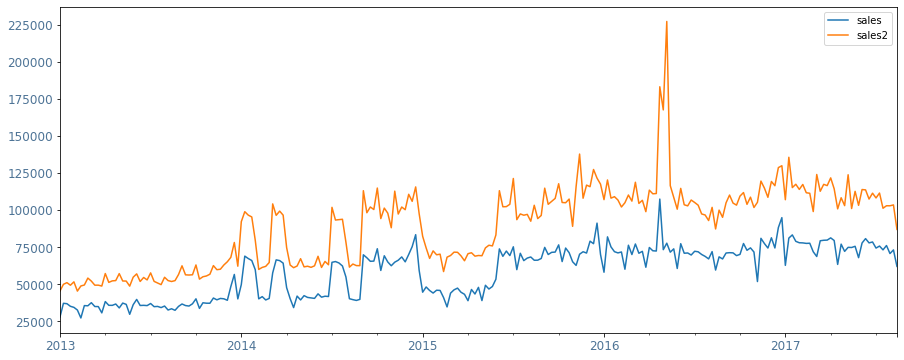

In [435]:
mul_df.plot(figsize= (15,6)).autoscale(axis='x',tight=True)
nice_plotting(new_fig= False)

# Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries



<b> From the documentation: </b> <br>
The Null hypothesis for grangercausalitytests is that the time series in
the second column, x2, does NOT Granger cause the time series in the first
column, x1. Grange causality means that past values of x2 have a
statistically significant effect on the current value of x1, taking past
values of x1 into account as regressors. We reject the null hypothesis
that x2 does not Granger cause x1 if the pvalues are below a desired size
of the test.

No need to difference series before applying this test!

In [401]:
# see if lagged values of sales2 Granger cause sales
grangercausalitytests(mul_df[['sales','sales2']], maxlag=3); # we inspect up to lag 3..based on the plots doesn't seem to make sense to consider many


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.8767 , p=0.0002  , df_denom=237, df_num=1
ssr based chi2 test:   chi2=14.0523 , p=0.0002  , df=1
likelihood ratio test: chi2=13.6563 , p=0.0002  , df=1
parameter F test:         F=13.8767 , p=0.0002  , df_denom=237, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8695  , p=0.0085  , df_denom=234, df_num=2
ssr based chi2 test:   chi2=9.9470  , p=0.0069  , df=2
likelihood ratio test: chi2=9.7456  , p=0.0077  , df=2
parameter F test:         F=4.8695  , p=0.0085  , df_denom=234, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4210  , p=0.0180  , df_denom=231, df_num=3
ssr based chi2 test:   chi2=10.5741 , p=0.0143  , df=3
likelihood ratio test: chi2=10.3459 , p=0.0158  , df=3
parameter F test:         F=3.4210  , p=0.0180  , df_denom=231, df_num=3


In [402]:
# see if lagged values of sales Granger cause sales2
grangercausalitytests(mul_df[['sales2', 'sales']], maxlag=3); # we inspect up to lag 3..based on the plots doesn't seem to make sense to consider many


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7166 , p=0.0012  , df_denom=237, df_num=1
ssr based chi2 test:   chi2=10.8522 , p=0.0010  , df=1
likelihood ratio test: chi2=10.6140 , p=0.0011  , df=1
parameter F test:         F=10.7166 , p=0.0012  , df_denom=237, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.6032  , p=0.0002  , df_denom=234, df_num=2
ssr based chi2 test:   chi2=17.5740 , p=0.0002  , df=2
likelihood ratio test: chi2=16.9579 , p=0.0002  , df=2
parameter F test:         F=8.6032  , p=0.0002  , df_denom=234, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.3087  , p=0.0001  , df_denom=231, df_num=3
ssr based chi2 test:   chi2=22.5904 , p=0.0000  , df=3
likelihood ratio test: chi2=21.5816 , p=0.0001  , df=3
parameter F test:         F=7.3087  , p=0.0001  , df_denom=231, df_num=3


<b> All p-values are very small, but I will pick the smallest, which is for lag 3 of second ts.
That means that a change at time t in sales, will be reflected in changes at time t+3 in sales2. That is first sales, then sales2

## VAR

Sales must be differenced (1), we already did before. Let's check sales2

In [431]:
adf_test(mul_df['sales2'],title='Sales Shop2') ## non stationary

Augmented Dickey-Fuller Test: Sales Shop 2
ADF test statistic       -2.082153
p-value                   0.251751
# lags used               9.000000
# observations          231.000000
critical value (1%)      -3.458980
critical value (5%)      -2.874135
critical value (10%)     -2.573482
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [432]:
adf_test(mul_df['sales2'].diff(1),title='Sales Shop2 differenced(1)')  ## stationary

Augmented Dickey-Fuller Test: Sales Shop2 differenced(1)
ADF test statistic     -6.481132e+00
p-value                 1.294213e-08
# lags used             8.000000e+00
# observations          2.310000e+02
critical value (1%)    -3.458980e+00
critical value (5%)    -2.874135e+00
critical value (10%)   -2.573482e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


It is enough to difference both by 1, so let's do that:

In [436]:
mul_df1= mul_df.diff(1).dropna()
mul_df1.head()

,sales,sales2
date,,
2013-01-13,9241.92,4527.47
2013-01-20,-248.74,1126.62
2013-01-27,-1766.46,-1737.16
2013-02-03,-707.40,2277.42
2013-02-10,-1804.45,-6239.36


<b> Train/test split </b> <br>
I need to use differenced version because these libraries do not have internal parameter such as typ='levels' to invert the diff transofrmation

In [437]:
diff_train, diff_test = mul_df1[0:-test_size], mul_df1[-test_size:]
diff_train.shape, diff_test.shape

((212, 2), (28, 2))

<b> Choosing order </b>: There is no auto-arima for VAR. <br> We'll fit a series of models, and base our final selection on the model that provides the lowest BIC score.

In [452]:
model = VAR(diff_train)

for i in [1,2,3,4,5,6]: 
    results = model.fit(i)
    print('Order =', i)
#     print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
BIC:  36.76392515986447

Order = 2
BIC:  36.734170979766205

Order = 3
BIC:  36.76501507440684

Order = 4
BIC:  36.80892654308862

Order = 5
BIC:  36.83927153196241

Order = 6
BIC:  36.89102629470404



The VAR(2) model seems to return the lowest combined scores.<br>
Just to verify that both variables are included in the model we can run <tt>.endog_names</tt>

In [451]:
model.endog_names

['sales', 'sales2']

<b> Fit the VAR(2) Model

In [455]:
var = model.fit(2)
var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Nov, 2021
Time:                     18:17:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    36.7342
Nobs:                     210.000    HQIC:                   36.6392
Log likelihood:          -4426.31    FPE:                7.66011e+15
AIC:                      36.5748    Det(Omega_mle):     7.30797e+15
--------------------------------------------------------------------
Results for equation sales
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const           286.497358       565.070013            0.507           0.612
L1.sales         -0.478174         0.085770           -5.575           0.000
L1.sales2         0.094216         0.051991            1.812           0.070

##### Predict the next 24 values
Unlike the VARMAX model we'll use in upcoming sections, the VAR <tt>.forecast()</tt> function requires that we pass in a lag order number of previous observations as well. Unfortunately this forecast tool doesn't provide a DateTime index - we'll have to do that manually.

In [456]:
lag_order = var.k_ar
lag_order

2

In [512]:
z = var.forecast(y=diff_train.values[-lag_order:], steps=test_size)
z

array([[1745.92661309,  222.62245945],
       [-698.57394104, -232.0283798 ],
       [ 196.79557413,  977.20034836],
       [ 428.50404392,  -78.0459575 ],
       [ 140.5553268 ,  316.35273078],
       [ 134.90515294,  360.50992045],
       [ 258.58468644,  273.53374912],
       [ 197.81112348,  266.0356037 ],
       [ 185.65189401,  312.22822767],
       [ 209.83660306,  289.252764  ],
       [ 204.50290431,  285.76597062],
       [ 198.10318516,  294.02854432],
       [ 202.84053874,  292.18644962],
       [ 202.93903199,  289.91601212],
       [ 201.30082376,  291.61814716],
       [ 201.95424762,  291.6268172 ],
       [ 202.24371724,  291.05704662],
       [ 201.89246217,  291.28967133],
       [ 201.94459208,  291.38956736],
       [ 202.04244866,  291.26522333],
       [ 201.98287265,  291.2848503 ],
       [ 201.97464595,  291.31886216],
       [ 201.99868876,  291.29769471],
       [ 201.9912014 ,  291.29500718],
       [ 201.98615354,  291.30345971],
       [ 201.99088398,  2

In [513]:
diff_test.head()

,sales,sales2
date,,
2017-02-05,-92.55,3342.11
2017-02-12,-332.59,-5592.47
2017-02-19,106.06,-349.73
2017-02-26,-5775.00,-12343.29
2017-03-05,-3180.43,25012.91


In [515]:
idx = pd.date_range('2017-02-05', periods=test_size, freq='W-SUN')
df_forecast = pd.DataFrame(z, index=idx, columns=['sales_d','sales2_d'])
df_forecast.head()

,sales_d,sales2_d
2017-02-05,1745.926613,222.622459
2017-02-12,-698.573941,-232.028380
2017-02-19,196.795574,977.200348
2017-02-26,428.504044,-78.045958
2017-03-05,140.555327,316.352731


#### Forecasting into the unknown future with manual diff inversion

We need to apply reverse transformation of differencing, to be in the same original scale


#### Inverting the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [518]:
mul_df_forecast = mul_df.copy()

# I am adding to the cum sum of sales, the first observation before the test set starts (-test_size - 1)
# Now build the forecast values from the first difference set

mul_df_forecast['SalesForecast'] = mul_df['sales'].iloc[-test_size-1] + df_forecast['sales_d'].cumsum()
mul_df_forecast['Sales2Forecast'] = mul_df['sales2'].iloc[-test_size-1] + df_forecast['sales2_d'].cumsum()
mul_df_forecast.tail()

,sales,sales2,SalesForecast,Sales2Forecast
date,,,,
2017-07-16,73050.20,101135.36,83470.648437,120632.501330
2017-07-23,75973.00,102815.47,83672.634591,120923.804790
2017-07-30,70559.26,102799.52,83874.625475,121215.105542
2017-08-06,73001.49,103375.27,84076.616070,121506.404554
2017-08-13,61877.27,86851.59,84278.605162,121797.705239


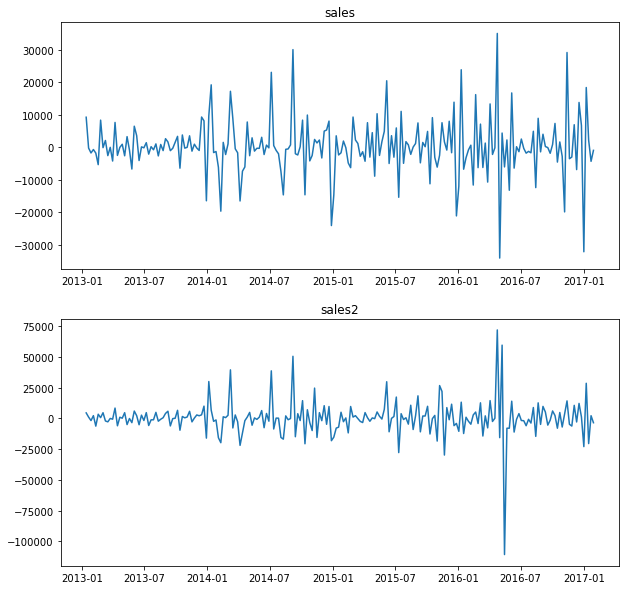

In [519]:
var.plot();

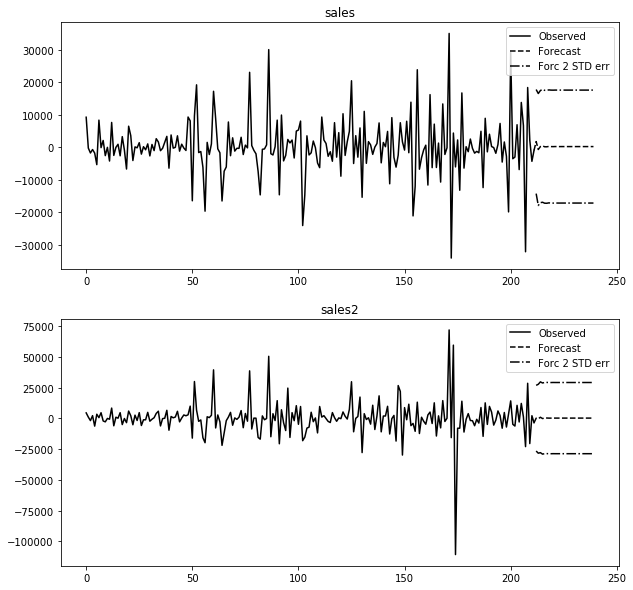

In [520]:
var.plot_forecast(test_size);

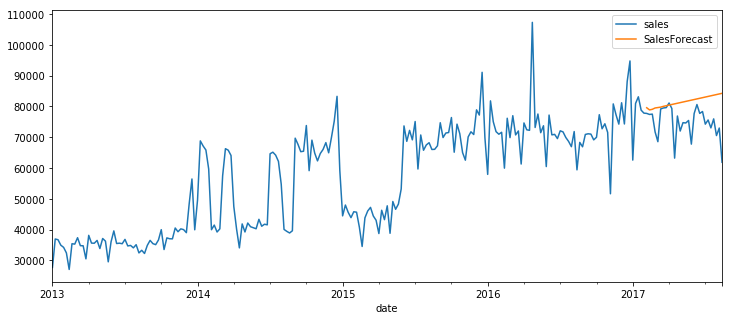

In [656]:
mul_df_forecast['sales'].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
mul_df_forecast['SalesForecast'].plot(legend=True);

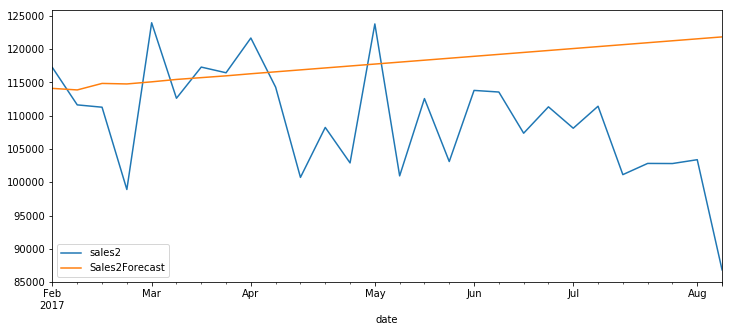

In [523]:
mul_df_forecast['sales2'][-test_size:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
mul_df_forecast['Sales2Forecast'].plot(legend=True);

# VARMA(p,q)
## Vector Autoregressive Moving Average
In a <strong>VARMA(p,q)</strong> model we give the error terms $\varepsilon_t$ a moving average representation of order $q$.


### Formulation
We've seen that an autoregressive moving average ARMA(p,q) model is described by the following:

&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

A $K$-dimensional VARMA model of order $(p,q)$ considers each variable $y_K$ in the system.<br>

For example, the system of equations for a 2-dimensional VARMA(1,1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \theta_{11,1}\varepsilon_{1,t-1} + \theta_{12,1}\varepsilon_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \theta_{21,1}\varepsilon_{1,t-1} + \theta_{22,1}\varepsilon_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\theta_{ii,l}$ captures the influence of the $l$th lag of error $\varepsilon_i$ on itself,<br>
the coefficient $\theta_{ij,l}$ captures the influence of the $l$th lag of error $\varepsilon_j$ on $\varepsilon_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are residual white noise.<br>


The general steps involved in building a VARMA model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate <em>p</em> and <em>q</em> orders
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

<b> Choosing VARMA order </b> <br>

1. As for VAR, there is not a library such as auto_arima, I'd need to run for loops and see best BIC.
2. Another approach is to run auto_arima on the two individual time series, and choose order accordingly. <br>
For instance ts2 has (1, 2, 2), ts2 has (1, 1, 2), I should difference both based on the highest d, which is 2. Then a VARMA(1,2) would be ok.
    - problem with this approach: if ts1 has (1, 2, 2), and ts2 has (3,0,4), should I choose VARMA (3,2,4)? Basically to be on the safe side, I pick the maximum of each parameter? It is better method 1.

In [663]:
## Assuming I did point 1. to choose order, I fit VARMAX

model = VARMAX(diff_train, order=(1, 1),
#                exog= train['holidays']  ## if I want to add exog variable
               trend='c')  ## trend ='c' means constant intercept term
                
varma = model.fit(maxiter=1000, disp=False)
varma.summary()

Dep. Variable:,"['sales', 'sales2']",No. Observations:,212
Model:,"VARMA(1,1)",Log Likelihood,-4453.892
,+ intercept,AIC,8933.784
Date:,"Fri, 26 Nov 2021",BIC,8977.420
Time:,13:52:51,HQIC,8951.421
Sample:,01-13-2013,,
,- 01-29-2017,,
Covariance Type:,opg,,
Ljung-Box (Q):,"75.83, 40.79",Jarque-Bera (JB):,"129.50, 1910.53"
Prob(Q):,"0.00, 0.44",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"3.07, 5.87",Skew:,"0.05, 1.85"


<b> Predicting unknown future with VARMA </b> <br>
Unlike the VAR model we used in the previous section, the VARMAX <tt>.forecast()</tt> function won't require that we pass in a number of previous observations, and it will provide an extended DateTime index.

In [665]:
varma_forecast = varma.forecast(test_size)
varma_forecast.head()

,sales,sales2
2017-02-05,-887.143107,2365.132345
2017-02-12,-125.335653,699.324514
2017-02-19,109.563713,425.686685
2017-02-26,154.271238,281.352836
2017-03-05,173.436233,276.929399


I should then invert the transformation manually (as did for VAR) and plot/evaluate the forecast.

# Deep Learning Methods

In [439]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train[['sales']])
scaled_test= scaler.transform(test[['sales']])

scaled_test.shape

(28, 1)

#### Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [440]:
# define generator. Usually small batch size for ts is fine, even 1

sequence_length = 7 ## weekly sequence, but I can choose this as I want, it is the lenght of the sequence, how much memory I want to keep
n_features = 1
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=sequence_length, batch_size=batch_size)

In [441]:
len(scaled_train), len(generator) # n_input = 7

(213, 206)

In [442]:
### Inspecting Generator

print(f'First 4 values of scaled train: {scaled_train[:8]}')

# What does the first batch look like?
X,y = generator[0]

print(f'\nGiven the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

First 4 values of scaled train: [[0.00810276]
 [0.12327158]
 [0.12017189]
 [0.09815903]
 [0.08934371]
 [0.06685744]
 [0.        ]
 [0.10404886]]

Given the Array: 
[0.00810276 0.12327158 0.12017189 0.09815903 0.08934371 0.06685744
 0.        ]
Predict this y: 
 [[0.10404886]]


### Creating RNN Model

In [443]:
early_stop = EarlyStopping(monitor='val_loss',patience=20)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=n_input, batch_size=batch_size)

##### Defining Early Stopping to avoid overfitting; if within {patience} epochs val_loss does not increase, stop training

In [444]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model without early stopping
# model.fit_generator(generator,epochs=20)


# fit model using early stopping

model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
206/206 [==============================] - 1s 3ms/step - loss: 0.0278 - val_loss: 0.0042
Epoch 2/20
206/206 [==============================] - 0s 2ms/step - loss: 0.0148 - val_loss: 0.0045
Epoch 3/20
206/206 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0057
Epoch 4/20
206/206 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0081
Epoch 5/20
206/206 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0062
Epoch 6/20
206/206 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0066
Epoch 7/20
206/206 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0079
Epoch 8/20
206/206 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0098
Epoch 9/20
106/206 [===========>..................] - ETA: 0s - loss: 0.008

limit_output extension: Maximum message size of 10000 exceeded with 10061 characters

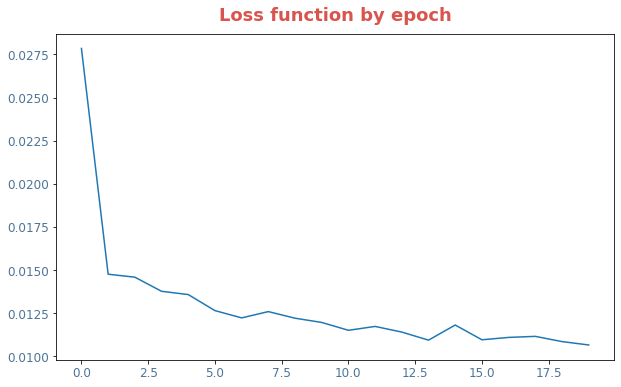

In [445]:
nice_plotting(title= 'Loss function by epoch', new_fig = True)
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [446]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [447]:
## Saving model

model.save('lstm_model.h5')

## loading model
from tensorflow.keras.models import load_model
trained_model = load_model('lstm_model.h5')

In [448]:
lstm_train_pred= model.predict_generator(generator)
lstm_train_pred= scaler.inverse_transform(lstm_train_pred)

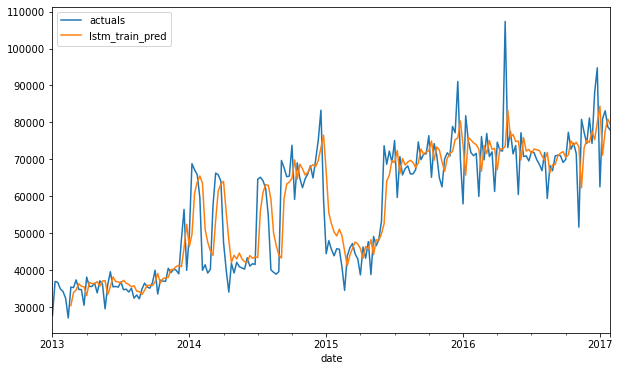

In [461]:
ax= train['sales'].plot(figsize=(10,6), label='actuals')
pd.DataFrame(lstm_train_pred, index=train.index[7:], columns=['lstm_train_pred'] ).plot(ax=ax)
plt.legend()

##### Evaluate on Test Data
- Since I used the TimeSeriesGenerator class to create the sequences based on the train set and such class does not have a way to transform the test data as well, in order to predict the test set we need to manually create the test sequences.

- In other words I cannot use generator for test, because what I am doing is to create sequences and to do that I cannot use test data. Instead, I have to add my predictions on top of the sequences

In [449]:
## Putting first batch into current_batch array
# I have to create test set this way:
# t1, t2, t3 --> t4
# t2, t3, t4 --> t5

scaled_test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    scaled_test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first one
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

<b> Getting test prediction on the original scale doing inverse transformation

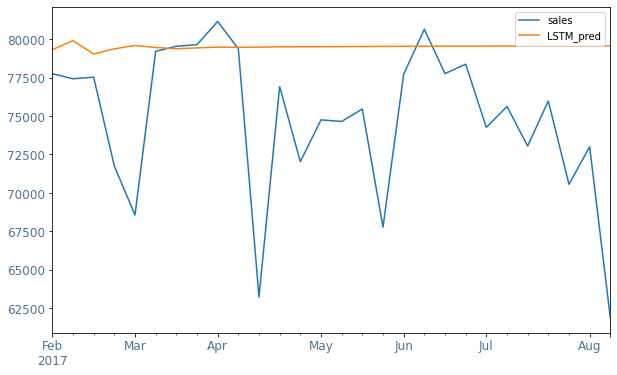

In [450]:
lstm_test_pred = scaler.inverse_transform(scaled_test_predictions)

test['LSTM_pred'] = lstm_test_pred


test[['sales', 'LSTM_pred']].plot(figsize=(10,6))

nice_plotting()

### Multivariate TS with RNN

In [132]:
mul_df1.head() ## differenced multivariate TS

,sales,sales2
date,,
2013-01-13,9241.92,4527.47
2013-01-20,-248.74,1126.62
2013-01-27,-1766.46,-1737.16
2013-02-03,-707.40,2277.42
2013-02-10,-1804.45,-6239.36


In [133]:
train, test = mul_df1[0:-test_size], mul_df1[-test_size:]

scaler= MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [141]:
## creating batches

sequence_length = 7 ## weekly sequence, but I can choose this as I want, it is the lenght of the sequence, how much memory I want to keep
batch_size = 1
n_features = scaled_train.shape[1] ## it is number of series (columns) I have 


generator = TimeseriesGenerator(scaled_train, scaled_train, length=sequence_length, batch_size=batch_size)

In [142]:
### Inspecting Generator

print(f'First 8 values of scaled train: \n{scaled_train[:8]}')

# What does the first batch look like?
X,y = generator[0]

print(f'\nGiven the (8x2) flattened array: \n{X.flatten()}')
print(f'\nPredict this y: \n {y}')

First 8 values of scaled train: 
[[0.62693368 0.63070183]
 [0.48978244 0.61210328]
 [0.46784959 0.59644186]
 [0.48315426 0.61839677]
 [0.46730059 0.57182025]
 [0.41584514 0.62479258]
 [0.61403831 0.60956757]
 [0.49157829 0.63148239]]

Given the (8x2) flattened array: 
[0.62693368 0.63070183 0.48978244 0.61210328 0.46784959 0.59644186
 0.48315426 0.61839677 0.46730059 0.57182025 0.41584514 0.62479258
 0.61403831 0.60956757]

Predict this y: 
 [[0.49157829 0.63148239]]


In [147]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(sequence_length ,n_features))) # n_features = n series I am using

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [148]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=sequence_length, batch_size=batch_size)


model.fit_generator(generator,epochs=15,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/15
205/205 [==============================] - 3s 6ms/step - loss: 0.0233 - val_loss: 0.0082
Epoch 2/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0145 - val_loss: 0.0128
Epoch 3/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 4/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0128 - val_loss: 0.0065
Epoch 5/15
107/205 [============>.................] - ETA: 0s - loss: 0.008

limit_output extension: Maximum message size of 10000 exceeded with 10050 characters

<AxesSubplot:>

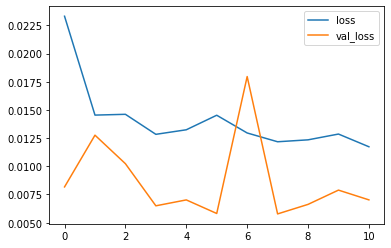

In [149]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [150]:
## Getting test prediction; reconstructing sequence as we did for univariate TS

n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-sequence_length:]
current_batch = first_eval_batch.reshape((1, sequence_length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [158]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions = pd.DataFrame(data=true_predictions,columns=['pred_sales', 'pred_sales2'], index= test.index)


test_pred= mul_df.iloc[-test_size:].join(true_predictions)
test_pred.head()

,sales,sales2,pred_sales,pred_sales2
date,,,,
2017-02-05,77750.39,117191.61,3523.477326,1600.041765
2017-02-12,77417.80,111599.14,2568.127966,603.182260
2017-02-19,77523.86,111249.41,3034.000240,2528.869420
2017-02-26,71748.86,98906.12,3511.367641,3582.763636
2017-03-05,68568.43,123919.03,3262.822137,2946.237513


To evaluate error of multivariate there are many ways. One is to take average RMSE for all the series

# Facebook Prophet

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [171]:
## Readapting data to FB format

new_df= df[['sales']].reset_index()
new_df.columns= ['ds','y']
new_df['ds'] = pd.to_datetime(new_df['ds'])

new_df.head()

,ds,y
0,2013-01-06,27728.15
1,2013-01-13,36970.07
2,2013-01-20,36721.33
3,2013-01-27,34954.87
4,2013-02-03,34247.47


In [369]:
test_size= 28 #4 weeks

# Set one month for testing
train = new_df.iloc[:len(df) - test_size]
test = new_df.iloc[len(train):]

train.shape, test.shape

((213, 2), (28, 2))

In [370]:
## Prophet internally detects if there is weekly or daily seasonality.
## If I get warning, it is because it does not detect them

periods_forecast= test_size + 7 # I predict one week into the unknown future

m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods= periods_forecast ,freq='W-SUN')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [375]:
train_pred_prophet = m.predict(train)[['ds','yhat']]
test_pred_prophet= m.predict(test)[['ds','yhat']]


train_pred_prophet.head()

,ds,yhat
0,2013-01-06,33397.641143
1,2013-01-13,34804.677494
2,2013-01-20,37806.184825
3,2013-01-27,38116.788047
4,2013-02-03,33926.785061


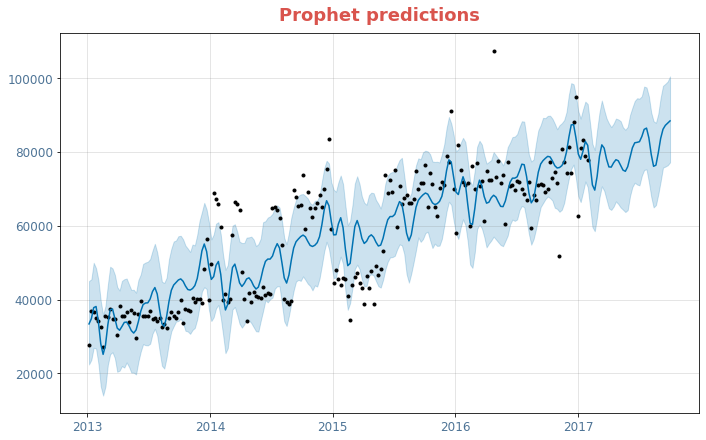

In [229]:
m.plot(forecast)
nice_plotting(title='Prophet predictions');

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

<b> Evaluating Prophet predictions

The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

In [217]:
## defining training period, folds window (period) and forecast horizon

# Initial training period
initial = len(train)
initial = str(initial) + ' w'  ##weeks
# Fold every N years
period = len(train)
period = str(period) + ' w'
# Forecast N weeks into the future
horizon = 4
horizon = str(horizon) + ' w'

In [231]:
df_cv = cross_validation(m,  horizon= '28 W') # initial = initial, period= period

INFO:fbprophet:Making 8 forecasts with cutoffs between 2014-08-31 00:00:00 and 2016-07-17 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

In [342]:
performance_metrics(df_cv).head(10)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,21 days,2.488592e+08,15775.271806,12730.231920,0.196824,0.143840,0.465909
1,28 days,2.117141e+08,14550.399116,11326.913130,0.186953,0.165125,0.522727
2,35 days,1.529557e+08,12367.525078,9599.307059,0.172868,0.106765,0.613636
3,42 days,1.805208e+08,13435.801895,10113.359490,0.182785,0.120878,0.636364
4,49 days,2.478056e+08,15741.843814,12095.268512,0.220852,0.123476,0.579545
5,56 days,2.574812e+08,16046.220170,12826.595381,0.231728,0.147802,0.522727
6,63 days,2.259851e+08,15032.801187,12338.224328,0.218664,0.153486,0.465909
7,70 days,1.605596e+08,12671.212090,10468.303906,0.184198,0.151786,0.545455
8,77 days,1.535519e+08,12391.604909,9836.543382,0.181561,0.147955,0.545455
9,84 days,1.676494e+08,12947.949119,10474.951832,0.186174,0.139187,0.534091


Plotting metrics at chaning horizon

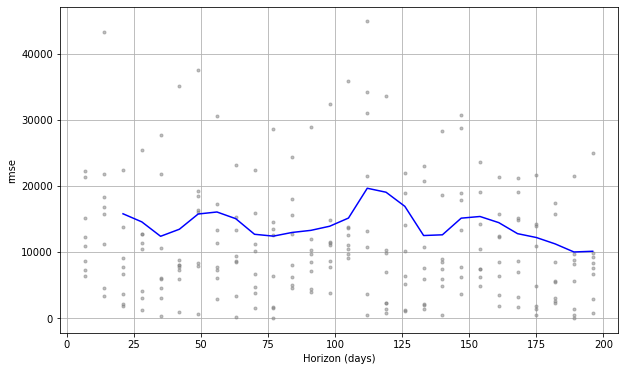

In [233]:
plot_cross_validation_metric(df_cv, metric='rmse');

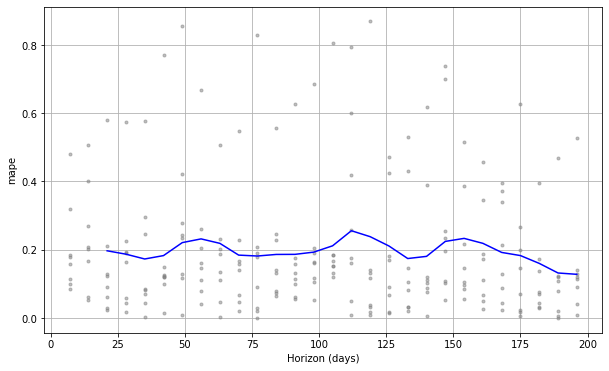

In [234]:
plot_cross_validation_metric(df_cv, metric='mape');

<b> Trend Changes

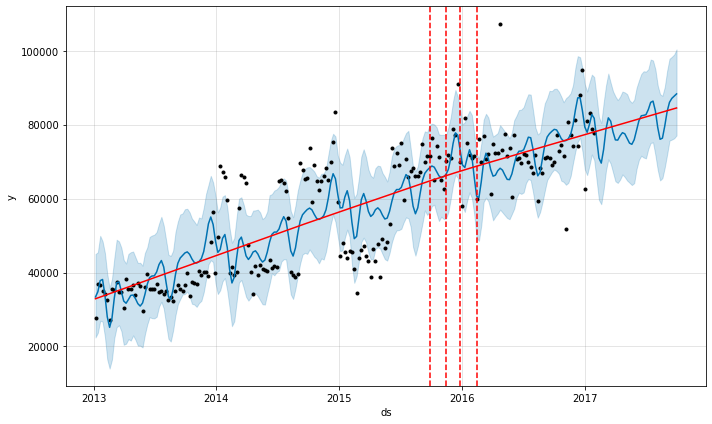

In [235]:
## checking cutoff points - between two red lines the trend has the same slope

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<b> Multiplicative model to accomodate non constant seasonality

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


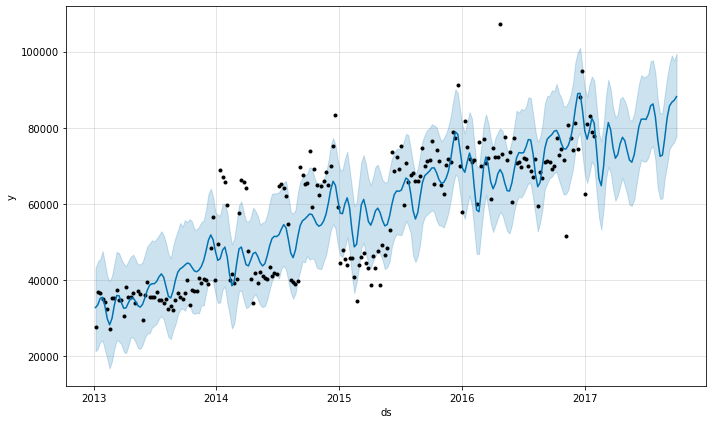

In [236]:
## Adding multiplicative seasonality to the model

m = Prophet(seasonality_mode='multiplicative')
m.fit(train)
forecast = m.predict(future)
fig = m.plot(forecast)

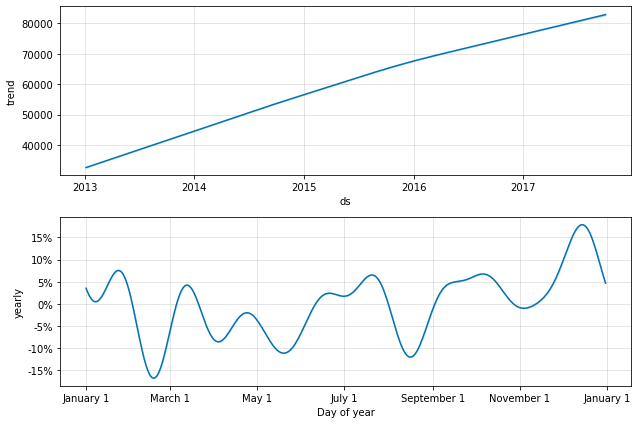

In [237]:
fig = m.plot_components(forecast)

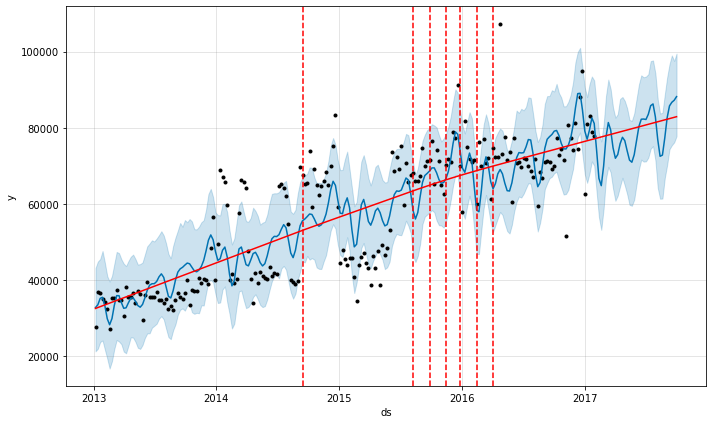

In [238]:
## Checking again cutoff points where trend changes

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Stacking Models

Take 3 models forecast: ARIMA, LSTM and Prophet. Then:

1. Compare train and val rmse for each
2. Average them and check rmse
3. Give them as input for LinearRegression (coefficients ~ weights of the models)
4. Give them as input for DecisionTree

In [486]:
validation_size= 28 # 3 months, 12 weeks

## lstm needs a sequence (=7) before having the prediction, so starting from date below to put same starting date to all models

train= df.iloc[: len(df) - validation_size].loc['2013-02-24':]
test= df.iloc[ -validation_size:]

In [465]:
train_pred_prophet= train_pred_prophet[train_pred_prophet['ds']>='2013-02-24']['yhat'].values
test_pred_prophet= test_pred_prophet.values

In [512]:
## Creating 

train_stacking= train[['sales']]
test_stacking= test[['sales']]

y_train= train_stacking['sales']
y_val= test_stacking['sales']


train_stacking.insert(0, 'arima', train_pred_arima  )
train_stacking.insert(0, 'lstm', lstm_train_pred  )
train_stacking.insert(0, 'prophet', train_pred_prophet  )

test_stacking.insert(0, 'arima', test_pred_arima  )
test_stacking.insert(0, 'lstm', lstm_test_pred  )
test_stacking.insert(0, 'prophet', test_pred_prophet  )

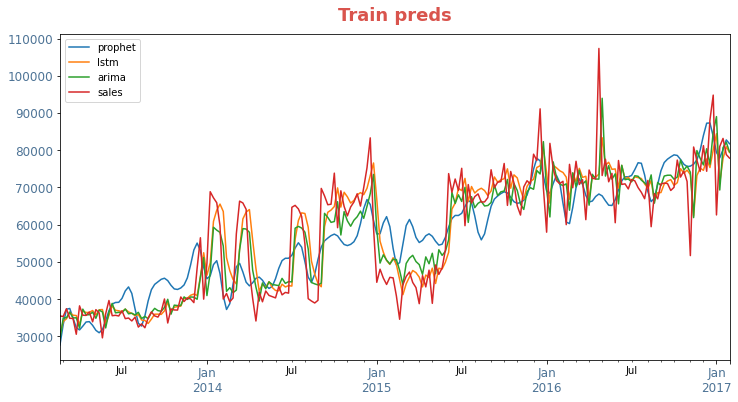

In [488]:
train_stacking.plot(figsize=(12, 6) )
plt.legend()
nice_plotting(title='Train preds', new_fig=False)

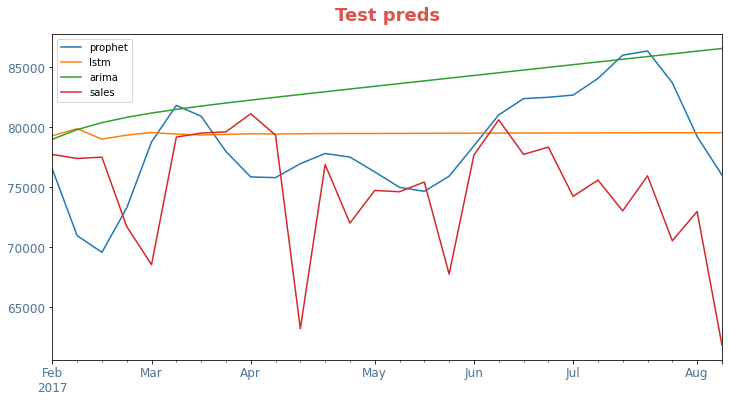

In [489]:
test_stacking.plot(figsize=(12, 6) )
plt.legend()
nice_plotting(title='Test preds', new_fig=False)

<b> Individual train/val rmse of models

In [501]:
models= train_stacking.columns[:3]

train_metrics= {}
val_metrics = {}

for col in models:
    print(f'\n{col}:')
    train_rmse= round(rmse(train_stacking[col], y_train))
    val_rmse= round(rmse(test_stacking[col], y_test)
    print(f'Train RMSE: {train_rmse}')
    print(f'Val RMSE: {val_rmse}')
    
    train_metrics[col]= train_rmse
    val_metrics[col]= val_rmse


prophet:
Train RMSE: 8945
Val RMSE: 7136

lstm:
Train RMSE: 7929
Val RMSE: 6718

arima:
Train RMSE: 7966
Val RMSE: 10319


#### Averaging models

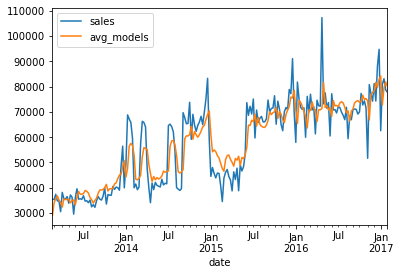

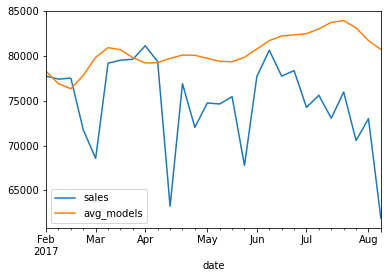

In [519]:
train_stacking['avg_models'] = train_stacking[models].mean(axis=1)
test_stacking['avg_models'] = test_stacking[models].mean(axis=1)



train_stacking[['sales', 'avg_models']].plot()

test_stacking[['sales', 'avg_models']].plot();

In [503]:
avg_rmse_train= round(rmse(train_stacking['avg_models'], y_train))
avg_rmse_val= round(rmse(test_stacking['avg_models'], y_test))

train_metrics['avg_models']= avg_rmse_train
val_metrics['avg_models']= avg_rmse_val

print(train_metrics)
print(val_metrics)

{'prophet': 8945, 'lstm': 7929, 'arima': 7966, 'avg_models': 7556}
{'prophet': 7136, 'lstm': 6718, 'arima': 10319, 'avg_models': 7716}


### Taking models outputs as inputs for LinearRegression (coefficients ~ weights of the models)

In [509]:
## not necessary to scale features for Linear Regression bcs it is scale invariant; 
## however, if I scale them, I can consider the coefficients as their weights

scaler= StandardScaler()

scaled_train= pd.DataFrame(scaler.fit_transform(train_stacking[models]), columns= models, index=train_stacking.index )
scaled_val= pd.DataFrame(scaler.transform(test_stacking[models]), columns= models, index=test_stacking.index)
                           
scaled_train.head()                

,prophet,lstm,arima
date,,,
2013-02-24,-2.118058,-1.803292,-1.870404
2013-03-03,-1.724915,-1.575773,-1.485505
2013-03-10,-1.431422,-1.525897,-1.482609
2013-03-17,-1.417156,-1.417177,-1.379262
2013-03-24,-1.604696,-1.463425,-1.487121


In [513]:
lr= LinearRegression()

lr.fit(scaled_train, y_train )

train_pred_lr= lr.predict(scaled_train)
test_pred_lr= lr.predict(scaled_val)

In [531]:
train_metrics['LR of models'] = round(rmse(train_pred_lr, y_train))
val_metrics['LR of models'] = round(rmse(test_pred_lr, y_val))

print('Train RMSE \n', train_metrics)
print('\nValidation RMSE \n', val_metrics)

Train RMSE 
 {'prophet': 8945, 'lstm': 7929, 'arima': 7966, 'avg_models': 7556, 'LR of models': 7417}

Validation RMSE 
 {'prophet': 7136, 'lstm': 6718, 'arima': 10319, 'avg_models': 7716, 'LR of models': 6152}


<AxesSubplot:xlabel='date'>

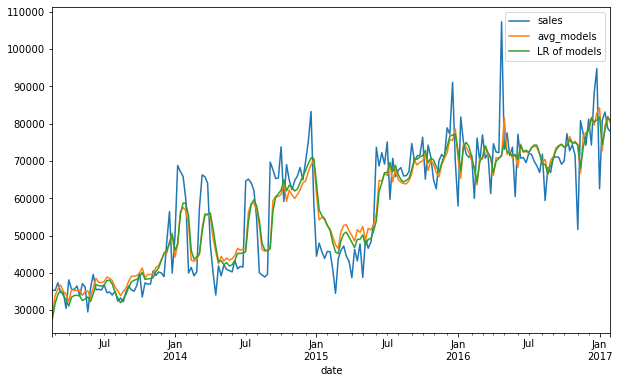

In [528]:
train_stacking['LR of models'] = train_pred_lr
test_stacking['LR of models'] = test_pred_lr


train_stacking[['sales', 'avg_models', 'LR of models']].plot(figsize=(10,6))
# test_stacking[['sales', 'avg_models', 'LR of models']].plot(figsize=(10,6));

#### Getting Models weights from LR
By doing weighted average using these weights, I'd get the output of LR

In [526]:
models_weights= lr.coef_

## Making them sum to 1
models_weights= models_weights/models_weights.sum(axis=0,keepdims=1)


models_weights= dict(zip(models, models_weights))
models_weights

{'prophet': 0.39155661886703025,
 'lstm': 0.79943303962071,
 'arima': -0.19098965848774013}

### Taking models outputs as inputs for DecisionTree

# Prediction Uncertainty Estimation

Exploit some statistical approach (e.g. boostrapping) to yield in output not only a single value but an interval representing the uncertainty on the prediction.
Examples:
https://towardsdatascience.com/add-prediction-intervals-to-your-forecasting-model-531b7c2d386c
https://towardsdatascience.com/state-space-model-and-kalman-filter-for-time-series-prediction-basic-structural-dynamic-linear-2421d7b49fa6 